 <h1><center>WRF HYDRO</center></h1>

## Libraries

In [1]:
import wrf as wrf
import pathlib
import netCDF4
import pandas as pd 
import xarray as xr 
import numpy as np 
import matplotlib.colors as clr

import matplotlib.font_manager as fm
from matplotlib import rcParams

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

import glob
import os

import fiona
import geopandas as gpd
import rioxarray

from osgeo import gdal

import warnings
warnings.filterwarnings('ignore')

## Functions 

In [11]:
def graf_dem_alos(lon_dem,lat_dem,dem_data): 

    fig,ax = plt.subplots(
        ncols=1,nrows=1,figsize=(10,8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    ax.set_global()
    ax.coastlines(lw=2,color='k')
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,33)
    lat_grid = np.arange(-80,86,33)
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), 
        draw_labels=True, 
        xlocs=lon_grid,ylocs=lat_grid,
        linewidth=.01, color='gray', alpha=0.5, linestyle='--'
    )
    
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    ax.set_extent([np.min(lon_dem), np.max(lon_dem), np.min(lat_dem), np.max(lat_dem)])
    cs = ax.contourf(lon_dem,lat_dem,dem_data,np.arange(0,3500,100),cmap='terrain')
    ax.text(xmin,ymax+.1,'DEM ALOS-PALSAR',fontsize=20,fontweight='bold')
    cbar_ax = fig.add_axes([0.88, 0.125, 0.04, 0.755])
    cbar = plt.colorbar(cs,cax=cbar_ax,orientation='vertical',ticks=[0,500,1000,1500,2000,2500,3000,3500,4000])
    cbar.set_label(r'MASL $[m]$',fontsize=16)
    cbar_ax.tick_params(labelsize=13)
    plt.show()


def graf_dem_hr(full_dom,run):
    path_font = '/Users/mzapata/Desktop/phd/ams/pros/'
    prop = fm.FontProperties(fname=path_font+'AvenirLTStd-Roman.ttf')
    rcParams['axes.edgecolor']=(0.45, 0.45, 0.45)
    rcParams['axes.labelcolor']=(0.45, 0.45, 0.45)
    rcParams[u'text.color']= (0.45, 0.45, 0.45)
    rcParams[u'ytick.color']=(0.45, 0.45, 0.45)
    rcParams[u'xtick.color']=(0.45, 0.45, 0.45)
    rcParams['font.size'] = 16.
    rcParams['axes.labelsize'] = 20.
    rcParams['xtick.labelsize'] = 14.
    rcParams['ytick.labelsize'] = 14.
    
    e = .001
    ymin = np.min(full_dom.LATITUDE.values) + e
    ymax = np.max(full_dom.LATITUDE.values) + e
    xmin = np.min(full_dom.LONGITUDE.values) - e
    xmax = np.max(full_dom.LONGITUDE.values) - e

    if run == 'test':
        fig,ax = plt.subplots(
            ncols=1,nrows=1,figsize=(15,6),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

    if run == 'magd':
        fig,ax = plt.subplots(
            ncols=1,nrows=1,figsize=(6,15),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )
    
    ax.set_global()
    ax.coastlines(lw=1)
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,33)
    lat_grid = np.arange(-80,86,33)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    ax.set_extent([xmin, xmax, ymin, ymax])

    if run == 'test':
        mapa = ax.contourf(
            full_dom.LONGITUDE.values,
            full_dom.LATITUDE.values,
            full_dom.TOPOGRAPHY.values,
            np.arange(1000,4500,10),
            cmap='terrain'
        )
        
        maps = ax.contour(
            full_dom.LONGITUDE.values,
            full_dom.LATITUDE.values,
            full_dom.TOPOGRAPHY.values,
            [1000,1500,2000,2500,3000,3500,4000],
            colors='k'
        )

    if run == 'magd':
        mapa = ax.contourf(
            full_dom.LONGITUDE.values,
            full_dom.LATITUDE.values,
            full_dom.TOPOGRAPHY.values,
            np.arange(0,4500,10),
            cmap='terrain'
        )
        
        maps = ax.contour(
            full_dom.LONGITUDE.values,
            full_dom.LATITUDE.values,
            full_dom.TOPOGRAPHY.values,
            [1000,2000,3000,4000],
            colors='k'
        )
    
    ax.clabel(maps,inline=True,fmt='%2.1f',fontsize=10)
    if run == 'test':
        ax.text(xmin,ymax+.01,'Fulldom high Resolution',fontsize=20,fontweight='bold')
        cbar_ax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
    if run == 'magd':
        ax.text(xmin,ymax+.1,'Fulldom high Resolution',fontsize=20,fontweight='bold')
        cbar_ax = fig.add_axes([0.92, 0.202, 0.04, 0.6])
    
    cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[1000,2000,3000,4000])
    cbar1.set_label(r'MASL $[m]$',fontsize=18)
    cbar1.ax.tick_params(labelsize=14)
    
    plt.show()

def graf_dir_hr(full_dom,run):
    path_font = '/Users/mzapata/Desktop/phd/ams/pros/'
    prop = fm.FontProperties(fname=path_font+'AvenirLTStd-Roman.ttf')
    rcParams['axes.edgecolor']=(0.45, 0.45, 0.45)
    rcParams['axes.labelcolor']=(0.45, 0.45, 0.45)
    rcParams[u'text.color']= (0.45, 0.45, 0.45)
    rcParams[u'ytick.color']=(0.45, 0.45, 0.45)
    rcParams[u'xtick.color']=(0.45, 0.45, 0.45)
    rcParams['font.size'] = 16.
    rcParams['axes.labelsize'] = 20.
    rcParams['xtick.labelsize'] = 14.
    rcParams['ytick.labelsize'] = 14.
    
    lev = [0,1,2,4,8,16,32,64,128]
    color = [(0.0, 1.0, 1.0),(0.0, 0.75, 1.0),(0.27, 0.86, 0.18),(1.0, 0.84, 0.0),\
             (1.0, 0.5, 0.0),(1.0, 0.0, 0.0),(0.623, 0.123, 0.941),(1.0, 0.0, 1.0)]
    my_colorbar, norm = clr.from_levels_and_colors(lev, color)
    
    e = .001
    ymin = np.min(full_dom.LATITUDE.values) + e
    ymax = np.max(full_dom.LATITUDE.values) + e
    xmin = np.min(full_dom.LONGITUDE.values) - e
    xmax = np.max(full_dom.LONGITUDE.values) - e
    
    if run == 'test':
        fig,ax = plt.subplots(
            ncols=1,nrows=1,figsize=(15,6),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

    if run == 'magd':
        fig,ax = plt.subplots(
            ncols=1,nrows=1,figsize=(6,15),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )
    
    ax.set_global()
    ax.coastlines(lw=1)
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,33)
    lat_grid = np.arange(-80,86,33)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    ax.set_extent([xmin, xmax, ymin, ymax])
    
    mapa = ax.pcolormesh(
        full_dom.LONGITUDE.values,
        full_dom.LATITUDE.values,
        full_dom.FLOWDIRECTION.values,
        cmap=my_colorbar,
        norm=norm
    )
    
    if run == 'test':
        ax.text(xmin,ymax+.01,'Flow Direction high Resolution',fontsize=20,fontweight='bold')
        cbar_ax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
    if run == 'magd':
        ax.text(xmin,ymax+.1,'Flow Direction high Resolution',fontsize=20,fontweight='bold')
        cbar_ax = fig.add_axes([0.92, 0.202, 0.04, 0.6])

    cbar = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical')
    loc = np.array((48,  96,  .5,   1.5,    3,   6,    12,  22))
    cbar.set_ticks(loc)
    cbar.set_ticklabels(['N','NE','E','SE','S','SW','W','NW'])
    cbar.set_label(r'Flow Direction',fontsize=20)
    plt.show()

def graf_acc_hr(full_dom,run):
    path_font = '/Users/mzapata/Desktop/phd/ams/pros/'
    prop = fm.FontProperties(fname=path_font+'AvenirLTStd-Roman.ttf')
    rcParams['axes.edgecolor']=(0.45, 0.45, 0.45)
    rcParams['axes.labelcolor']=(0.45, 0.45, 0.45)
    rcParams[u'text.color']= (0.45, 0.45, 0.45)
    rcParams[u'ytick.color']=(0.45, 0.45, 0.45)
    rcParams[u'xtick.color']=(0.45, 0.45, 0.45)
    rcParams['font.size'] = 16.
    rcParams['axes.labelsize'] = 20.
    rcParams['xtick.labelsize'] = 14.
    rcParams['ytick.labelsize'] = 14.
    
    e = .001
    ymin = np.min(full_dom.LATITUDE.values) + e
    ymax = np.max(full_dom.LATITUDE.values) + e
    xmin = np.min(full_dom.LONGITUDE.values) - e
    xmax = np.max(full_dom.LONGITUDE.values) - e
    
    if run == 'test':
        fig,ax = plt.subplots(
            ncols=1,nrows=1,figsize=(15,6),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

    if run == 'magd':
        fig,ax = plt.subplots(
            ncols=1,nrows=1,figsize=(6,15),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )
    
    ax.set_global()
    ax.coastlines(lw=1)
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,33)
    lat_grid = np.arange(-80,86,33)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    ax.set_extent([xmin, xmax, ymin, ymax])
    
    mapa = ax.pcolormesh(
        full_dom.LONGITUDE.values,
        full_dom.LATITUDE.values,
        full_dom.FLOWACC.values,
        cmap='Blues',
        vmin=0,
        vmax=1000
    )
    
    #ax.clabel(maps,inline=True,fmt='%2.1f',fontsize=10)
    #ax.text(xmin,ymax+.01,'Flow Accumulation high Resolution',fontsize=20,fontweight='bold')

    if run == 'test':
        ax.text(xmin,ymax+.01,'Flow Accumulation high Resolution',fontsize=20,fontweight='bold')
        cbar_ax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
    if run == 'magd':
        ax.text(xmin,ymax+.1,'Flow Accumulation high Resolution',fontsize=20,fontweight='bold')
        cbar_ax = fig.add_axes([0.92, 0.202, 0.04, 0.6])
    
    #cbar_ax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
    cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[200,400,600,800,1000])
    cbar1.set_label(r'Flow Accum $[num]$',fontsize=18)
    cbar1.ax.tick_params(labelsize=14)
    plt.show()

def catalogo_alos(xmin,xmax,ymin,ymax,ruta_data,plot):
    lista_folder = sorted(glob.glob(ruta_data+'/AP*'))
    col = ['x00', 'x10', 'x01', 'x11','y00', 'y10', 'y01', 'y11']
    catalogo = pd.DataFrame(columns=col)
    for idn, name_file in enumerate(lista_folder):
        lon, lat = tiff_cords(name_in=name_file)
        if ((lon[0] > xmin) == True) & ((lon[-1] < xmax) == True) &\
           ((lat[0] < ymax) == True) & ((lat[-1] > ymin) == True):
            xx, yy = np.meshgrid(lon,lat)
            catalogo.loc[name_file.split('/')[-1], 'x00'] = xx[0,0]
            catalogo.loc[name_file.split('/')[-1], 'x10'] = xx[-1,0]
            catalogo.loc[name_file.split('/')[-1], 'x01'] = xx[0,-1]
            catalogo.loc[name_file.split('/')[-1], 'x11'] = xx[-1,-1]
            catalogo.loc[name_file.split('/')[-1], 'y00'] = yy[0,0]
            catalogo.loc[name_file.split('/')[-1], 'y10'] = yy[-1,0]
            catalogo.loc[name_file.split('/')[-1], 'y01'] = yy[0,-1]
            catalogo.loc[name_file.split('/')[-1], 'y11'] = yy[-1,-1]
            
    if plot == 'si':
        fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,8),
              subplot_kw={'projection': ccrs.PlateCarree()})
        #ax.outline_patch.set_visible(False) 
        ax.set_global()
        ax.coastlines(lw=2,color='k')
        ax.spines['geo'].set_visible(False)
        lon_grid = np.arange(-180,181,4)
        lat_grid = np.arange(-80,86,4)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                  linewidth=.01, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlabel_style = {'size': 12, 'color': 'black'}
        gl.ylabel_style = {'size': 12, 'color': 'black'}
        ax.set_extent([-82, -64, -5, 14])
        ax.add_feature(cf.BORDERS,linewidth=1,color='k')
        ax.plot((xmin,xmax,xmax,xmin,xmin),(ymin,ymin,ymax,ymax,ymin),'--g',lw=2)
        plt.title('Catalogo ALOS-PALSAR 30m',fontsize=18)
        for jj in range(len(catalogo)):
            ax.plot((catalogo['x00'][jj],catalogo['x01'][jj],catalogo['x11'][jj],catalogo['x10'][jj],\
                     catalogo['x00'][jj]),(catalogo['y00'][jj],catalogo['y01'][jj],catalogo['y11'][jj],\
                                           catalogo['y10'][jj],catalogo['y00'][jj]),'r',lw=1)

        #plt.savefig('/Users/mzapata/Desktop/catalogo_02.png',dpi=200,transparent=True,bbox_inches="tight")
        plt.show()
        
    return catalogo

def tiff_cords(name_in):
    input_raster = rioxarray.open_rasterio(name_in)
    lon = input_raster.x.values
    lat = input_raster.y.values
    input_raster = None 
    return lon, lat

def get_fromtiff(name_tiff):
    var_tif = gdal.Open(name_tiff, gdal.GA_ReadOnly)
    gt = var_tif.GetGeoTransform()
    proj = var_tif.GetProjection()
    band_tif = var_tif.GetRasterBand(1)
    tif_data = band_tif.ReadAsArray()
    lon_tif, lat_tif= tiff_cords(name_in=name_tiff)
    return tif_data, lon_tif, lat_tif

def graf_test_streamflow(full_dom, ds_out, pos):
    path_font = '/Users/mzapata/Desktop/phd/ams/pros/'
    prop = fm.FontProperties(fname=path_font+'AvenirLTStd-Roman.ttf')
    rcParams['axes.edgecolor']=(0.45, 0.45, 0.45)
    rcParams['axes.labelcolor']=(0.45, 0.45, 0.45)
    rcParams[u'text.color']= (0.45, 0.45, 0.45)
    rcParams[u'ytick.color']=(0.45, 0.45, 0.45)
    rcParams[u'xtick.color']=(0.45, 0.45, 0.45)
    rcParams['font.size'] = 16.
    rcParams['axes.labelsize'] = 20.
    rcParams['xtick.labelsize'] = 14.
    rcParams['ytick.labelsize'] = 14.
    
    e = .001
    ymin = np.min(full_dom.LATITUDE.values) + e
    ymax = np.max(full_dom.LATITUDE.values) + e
    xmin = np.min(full_dom.LONGITUDE.values) - e
    xmax = np.max(full_dom.LONGITUDE.values) - e
    
    fig,ax = plt.subplots(
        ncols=1,nrows=1,figsize=(15,6),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    ax.set_global()
    ax.coastlines(lw=1)
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,33)
    lat_grid = np.arange(-80,86,33)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    ax.set_extent([xmin, xmax, ymin, ymax])
    
    mapa = ax.pcolormesh(
        full_dom.LONGITUDE.values,
        full_dom.LATITUDE.values,
        ds_out.streamflow.isel(time=pos).values,
        vmin=0,
        vmax=2,
        cmap='viridis'
    )
    aux_tilt = pd.to_datetime(ds_out.time.values[pos]).strftime('%b %d of %Y')
    ax.text(xmin,ymax+.01,f'Streamflow {aux_tilt}',fontsize=20,fontweight='bold')
    cbar_ax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
    cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[0,.5,1,1.5,2])
    cbar1.set_label(r'Streamflow $[m^{3}s^{-1}]$',fontsize=18)
    cbar1.ax.tick_params(labelsize=14)
    
    plt.show()

def graf_magdalena_streamflow(full_dom, ds_out, pos):
    path_font = '/Users/mzapata/Desktop/phd/ams/pros/'
    prop = fm.FontProperties(fname=path_font+'AvenirLTStd-Roman.ttf')
    rcParams['axes.edgecolor']=(0.45, 0.45, 0.45)
    rcParams['axes.labelcolor']=(0.45, 0.45, 0.45)
    rcParams[u'text.color']= (0.45, 0.45, 0.45)
    rcParams[u'ytick.color']=(0.45, 0.45, 0.45)
    rcParams[u'xtick.color']=(0.45, 0.45, 0.45)
    rcParams['font.size'] = 16.
    rcParams['axes.labelsize'] = 20.
    rcParams['xtick.labelsize'] = 14.
    rcParams['ytick.labelsize'] = 14.
    
    e = .001
    ymin = np.min(full_dom.LATITUDE.values) + e
    ymax = np.max(full_dom.LATITUDE.values) + e
    xmin = np.min(full_dom.LONGITUDE.values) - e
    xmax = np.max(full_dom.LONGITUDE.values) - e
    
    fig,ax = plt.subplots(
        ncols=1,nrows=1,figsize=(6,15),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    ax.set_global()
    ax.coastlines(lw=1)
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,33)
    lat_grid = np.arange(-80,86,33)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    ax.set_extent([xmin, xmax, ymin, ymax])
    
    mapa = ax.pcolormesh(
        full_dom.LONGITUDE.values,
        full_dom.LATITUDE.values,
        ds_out.streamflow.isel(time=pos).values,
        vmin=0,
        vmax=.1,
        cmap='viridis'
    )
    aux_tilt = pd.to_datetime(ds_out.time.values[pos]).strftime('%b %d of %Y')
    ax.text(xmin,ymax+.1,f'Streamflow {aux_tilt}',fontsize=20,fontweight='bold')
    cbar_ax = fig.add_axes([0.92, 0.202, 0.04, 0.6])
    cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[0,0.02,0.04,0.06,0.08,0.1])
    cbar1.set_label(r'Streamflow $[m^{3}s^{-1}]$',fontsize=18)
    cbar1.ax.tick_params(labelsize=14)
    plt.show()

## Path

In [4]:
path_test = pathlib.Path('/Volumes/phd_data/workshop/hydro_exm/example_case_coupled/DOMAIN/')
path_magd = pathlib.Path('/Volumes/phd_data/workshop/hydro_exm/magdalena_case_coupled/DOMAIN')

path_magd_results = pathlib.Path('/Volumes/phd_data/workshop/hydro_exm/runs/magdalena/arw/')
path_test_results = pathlib.Path('/Volumes/phd_data/workshop/hydro_exm/runs/test/arw/')

ruta_dat = pathlib.Path('/Volumes/phd_data/dataset/ALOS/LR/')
ruta_dem = pathlib.Path('/Volumes/phd_data/dataset/ALOS/LR/dem/')
ruta_slp = pathlib.Path('/Volumes/phd_data/dataset/ALOS/LR/slp/')

## Test Case

### Read data

In [5]:
full_dom = xr.open_dataset(path_test.joinpath('Fulldom_hires.nc'))
gw_basin = xr.open_dataset(path_test.joinpath('GWBASINS.nc'))
gw_buckp = xr.open_dataset(path_test.joinpath('GWBUCKPARM.nc'))
geo_ldasout = xr.open_dataset(path_test.joinpath('GEOGRID_LDASOUT_Spatial_Metadata.nc'))

In [10]:
full_dom

<xarray.Dataset>
Dimensions:        (y: 120, x: 204)
Coordinates:
  * y              (y) float64 1.646e+04 1.621e+04 ... -1.304e+04 -1.329e+04
  * x              (x) float64 -6.116e+04 -6.091e+04 ... -1.066e+04 -1.041e+04
Data variables: (12/15)
    crs            |S1 ...
    CHANNELGRID    (y, x) int32 ...
    FLOWDIRECTION  (y, x) int16 32 16 16 16 16 16 16 ... 16 16 16 16 128 128 64
    FLOWACC        (y, x) int32 39 20 14 12 7 6 1 10 11 ... 0 19 8 5 2 0 0 0 0
    TOPOGRAPHY     (y, x) float32 2.585e+03 2.613e+03 ... 1.722e+03 1.717e+03
    RETDEPRTFAC    (y, x) float32 ...
    ...             ...
    basn_msk       (y, x) int32 ...
    LAKEGRID       (y, x) int32 ...
    landuse        (y, x) float32 ...
    LKSATFAC       (y, x) float32 ...
    LATITUDE       (y, x) float32 40.11 40.11 40.11 40.11 ... 39.84 39.84 39.84
    LONGITUDE      (y, x) float32 -105.7 -105.7 -105.7 ... -105.1 -105.1 -105.1
Attributes: (12/19)
    Conventions:       CF-1.5
    GDAL_DataType:     Generic
    Source_Software:   WRF-Hydro GIS Pre-processor v5 (03/2018)
    history:           Created Mon Oct 01 14:46:29 2018
    processing_notes:  Created: Mon Oct 01 14:45:34 2018
    geogrid_used:      C:\Users\ksampson\Desktop\MB\geo_em.d02.nc
    ...                ...
    TRUELAT2:          41.0
    STAND_LON:         -105.0
    POLE_LAT:          90.0
    POLE_LON:          0.0
    MOAD_CEN_LAT:      39.960003
    CEN_LAT:           39.97351

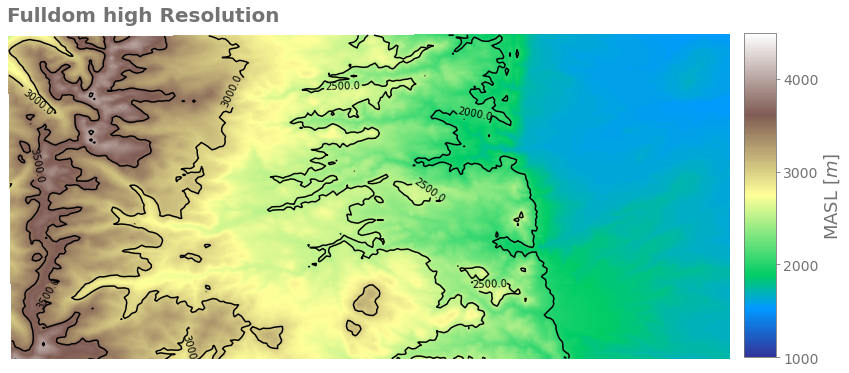

In [6]:
graf_dem_hr(full_dom, 'test')

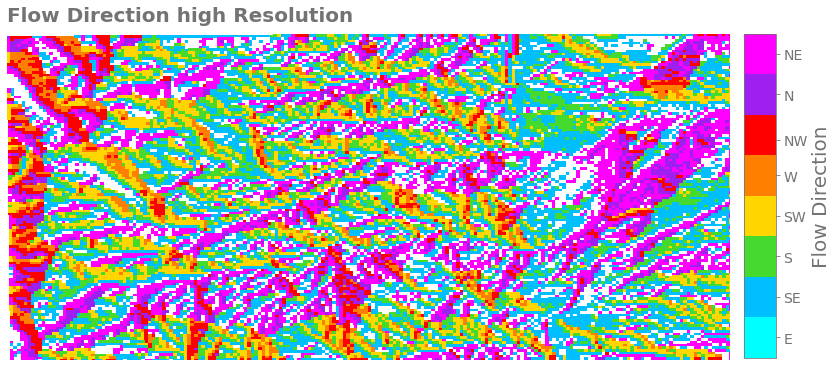

In [7]:
graf_dir_hr(full_dom,'test')

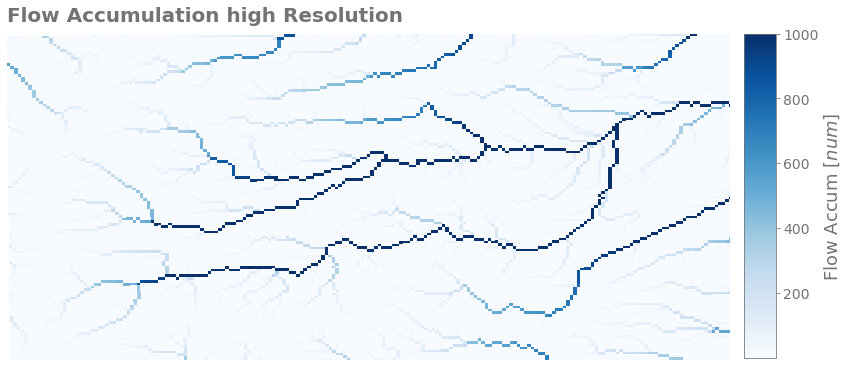

In [12]:
graf_acc_hr(full_dom,'test')

In [ ]:
full_dom.CHANNELGRID.plot()

## Postpro

In [13]:
ds_out_grid = xr.open_mfdataset(
    f'{path_test_results.as_posix()}/*.CHRTOUT_GRID2', 
    combine='by_coords'
)

ds_out_domain = xr.open_mfdataset(
    f'{path_test_results.as_posix()}/*.CHRTOUT_DOMAIN2', 
    combine='by_coords'
)

In [14]:
ds_out_domain

<xarray.Dataset>
Dimensions:         (time: 13, reference_time: 1, feature_id: 2553)
Coordinates:
  * time            (time) datetime64[ns] 2013-09-09T18:00:00 ... 2013-09-10T...
  * reference_time  (reference_time) datetime64[ns] 2013-09-09T18:00:00
  * feature_id      (feature_id) int32 1 2 3 4 5 6 ... 2549 2550 2551 2552 2553
    latitude        (feature_id) float32 dask.array<chunksize=(2553,), meta=np.ndarray>
    longitude       (feature_id) float32 dask.array<chunksize=(2553,), meta=np.ndarray>
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    order           (time, feature_id) int32 dask.array<chunksize=(1, 2553), meta=np.ndarray>
    elevation       (time, feature_id) float32 dask.array<chunksize=(1, 2553), meta=np.ndarray>
    streamflow      (time, feature_id) float32 dask.array<chunksize=(1, 2553), meta=np.ndarray>
    q_lateral       (time, feature_id) float32 dask.array<chunksize=(1, 2553), meta=np.ndarray>
    velocity        (time, feature_id) float32 dask.array<chunksize=(1, 2553), meta=np.ndarray>
    Head            (time, feature_id) float32 dask.array<chunksize=(1, 2553), meta=np.ndarray>
Attributes: (12/17)
    featureType:                timeSeries
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    model_initialization_time:  2013-09-09_18:00:00
    station_dimension:          feature_id
    model_output_valid_time:    2013-09-09_18:00:00
    model_total_valid_times:    0
    ...                         ...
    model_configuration:        default
    dev_OVRTSWCRT:              1
    dev_NOAH_TIMESTEP:          5
    dev_channel_only:           0
    dev_channelBucket_only:     0
    dev:                        dev_ prefix indicates development/internal me...

In [16]:
ds_out_grid

<xarray.Dataset>
Dimensions:         (time: 13, reference_time: 1, x: 204, y: 120)
Coordinates:
  * time            (time) datetime64[ns] 2013-09-09T18:00:00 ... 2013-09-10T...
  * reference_time  (reference_time) datetime64[ns] 2013-09-09T18:00:00
  * x               (x) float64 -6.116e+04 -6.091e+04 ... -1.066e+04 -1.041e+04
  * y               (y) float64 -1.329e+04 -1.304e+04 ... 1.621e+04 1.646e+04
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    index           (time, y, x) float64 dask.array<chunksize=(1, 120, 204), meta=np.ndarray>
    streamflow      (time, y, x) float32 dask.array<chunksize=(1, 120, 204), meta=np.ndarray>
Attributes:
    model_initialization_time:  2013-09-09_18:00:00
    model_output_valid_time:    2013-09-09_18:00:00
    model_total_valid_times:    0
    Conventions:                CF-1.6
    code_version:               v5.1.2
    model_output_type:          channel_rt
    model_configuration:        default
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    GDAL_DataType:              Generic

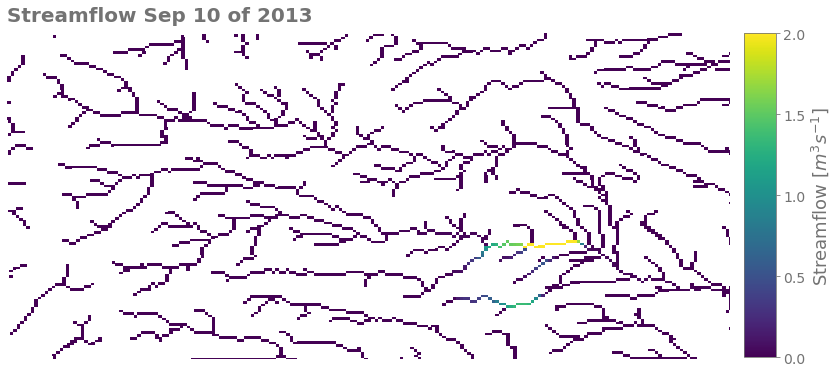

In [33]:
graf_test_streamflow(full_dom, ds_out_grid, 6)

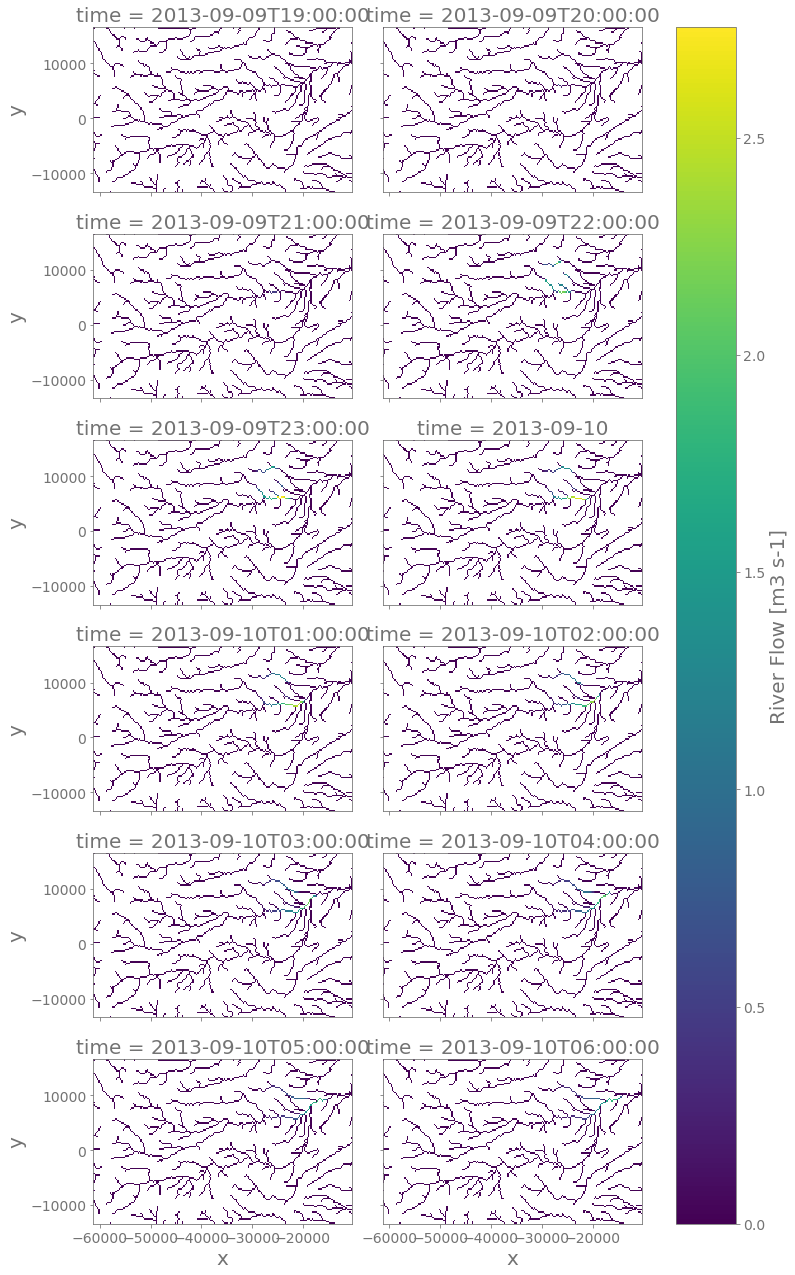

In [20]:
ds_out_grid.streamflow[1:].plot(
    col='time', 
    col_wrap=2, 
    vmin=0, 
    aspect=ds_out_grid.x.size/ds_out_grid.y.size
)

plt.show()

In [21]:
np.where(ds_out_grid.streamflow.values == np.nanmax(ds_out_grid.streamflow.values))

(array([5]), array([78]), array([148]))

In [22]:
ds_out_grid.index.values[5,78,148]

1671.0

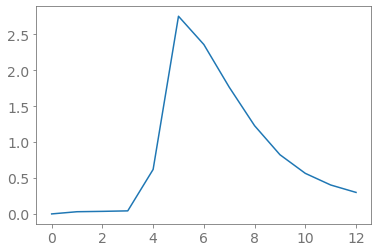

In [23]:
plt.plot(ds_out_grid.streamflow.values[:,78,148])

In [ ]:
plt.plot(ds_out_domain.sel(feature_id=1671).streamflow.values)

In [24]:
ds_lsm_domain = xr.open_mfdataset(
    f'{path_test_results.as_posix()}/*.LSMOUT_DOMAIN', 
    combine='by_coords'
)

ds_rt_domain = xr.open_mfdataset(
    f'{path_test_results.as_posix()}/*.RTOUT_DOMAIN2', 
    combine='by_coords'
)

In [27]:
ds_lsm_domain.info()

xarray.Dataset {
dimensions:
	time = 13 ;
	reference_time = 1 ;
	x = 51 ;
	y = 30 ;

variables:
	datetime64[ns] time(time) ;
		time:long_name = valid output time ;
		time:standard_name = time ;
		time:valid_min = 22979220 ;
		time:valid_max = 22979160 ;
	datetime64[ns] reference_time(reference_time) ;
		reference_time:long_name = model initialization time ;
		reference_time:standard_name = forecast_reference_time ;
	float64 x(x) ;
		x:resolution = 1000.0 ;
		x:standard_name = projection_x_coordinate ;
		x:long_name = x coordinate of projection ;
		x:units = m ;
		x:_CoordinateAxisType = GeoX ;
	float64 y(y) ;
		y:resolution = 1000.0 ;
		y:standard_name = projection_y_coordinate ;
		y:long_name = y coordinate of projection ;
		y:units = m ;
		y:_CoordinateAxisType = GeoY ;
	|S1 crs(time) ;
		crs:longitude_of_prime_meridian = 0.0 ;
		crs:standard_parallel = [39. 41.] ;
		crs:longitude_of_central_meridian = -105.0 ;
		crs:latitude_of_projection_origin = 39.959999084472656 ;
		crs:false_ea

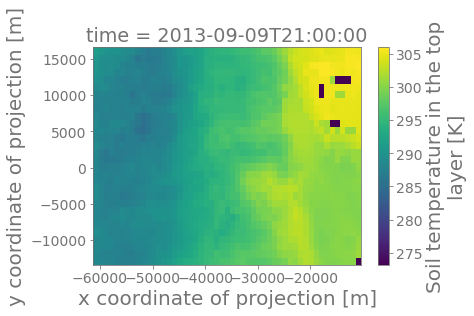

In [28]:
ds_lsm_domain.stc1.isel(time=3).plot()

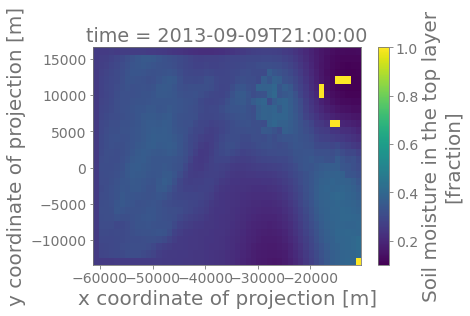

In [29]:
ds_lsm_domain.smc1.isel(time=3).plot()

In [30]:
wrf_path_list = sorted(list(path_test_results.rglob(f'wrfout*')))
df_info_wrf = {idd: [ii] for idd, ii in enumerate(wrf_path_list)}
df_info_wrf = pd.DataFrame.from_dict(df_info_wrf, orient='index', columns=['path'])

In [31]:
lev  = np.array([0.,5.0,10.0,20.,30.,40.,50.,75.,100.,150,200.,250,300.,350.])/20.
bar_colors  = np.array(\
               [(255, 255, 255),(255, 255, 255),(0, 255, 255),(0, 0, 255),(80,76,153),\
               (44, 141, 29), (70, 220, 45),\
               (255,255,75),(255, 200,50),(255,142,0), (255,0,0),(158, 29, 0),\
               (128,0,128),(252, 201, 255)])
Custom_Color = list(map(lambda x: tuple(ti/255. for ti in x) , bar_colors))
VariableLimits = np.array(lev)
scale_factor=((255-0.)/(VariableLimits.max() - VariableLimits.min()))
new_Limits = list(np.array(np.round((VariableLimits-VariableLimits.min())*\
                                    scale_factor/255.,3),dtype = float))
nueva_tupla=[((new_Limits[i]),Custom_Color[i],) for i in range(len(Custom_Color))]
cmap_rain = clr.LinearSegmentedColormap.from_list('RADAR',nueva_tupla)
levels_nuevos = np.linspace(np.min(VariableLimits),np.max(VariableLimits),255)
norm_rain = clr.BoundaryNorm(boundaries=levels_nuevos, ncolors=256)

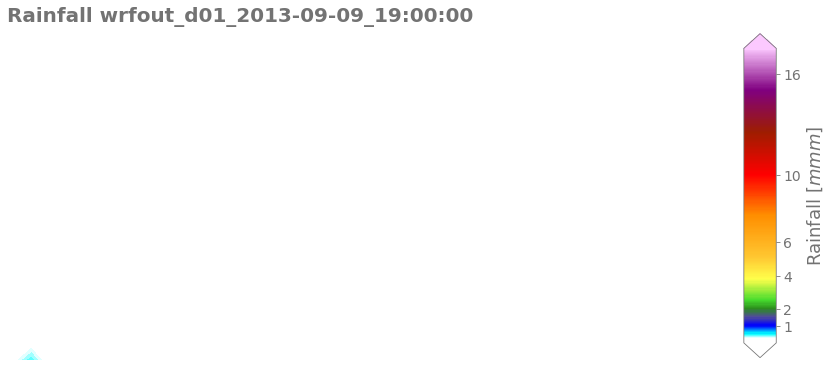

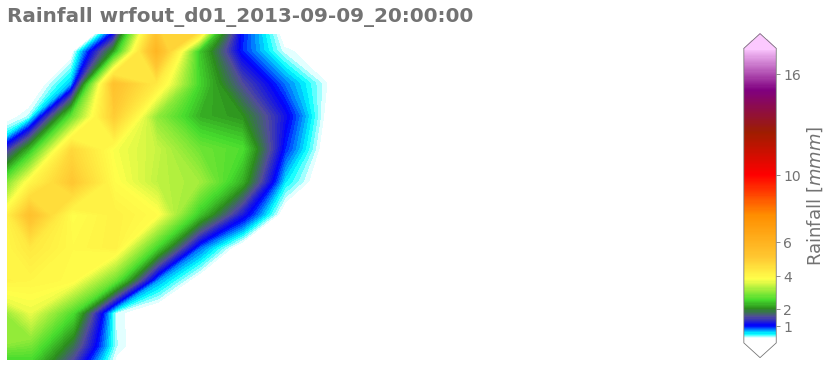

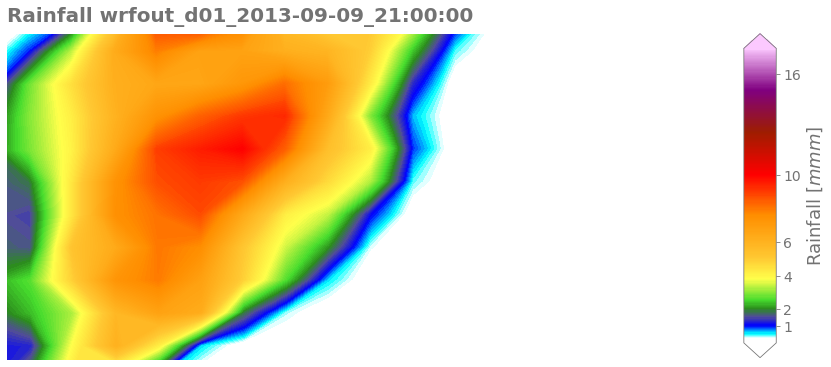

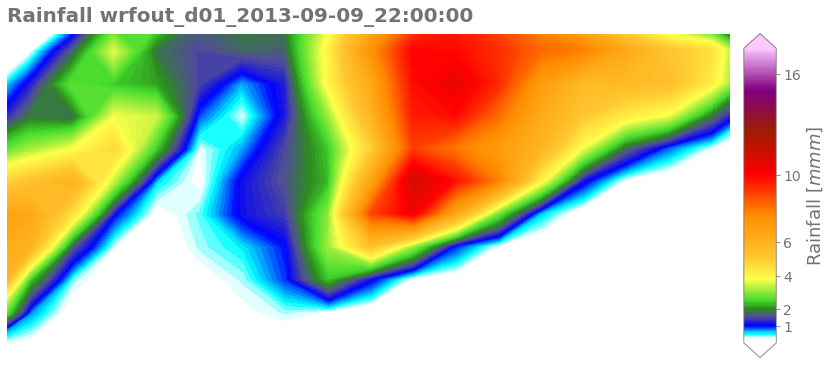

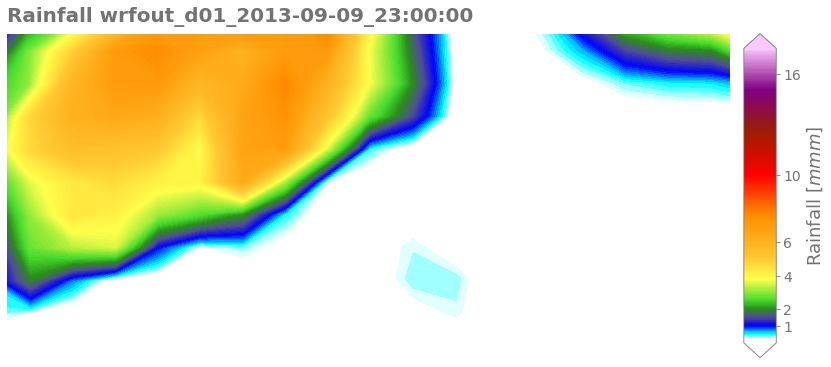

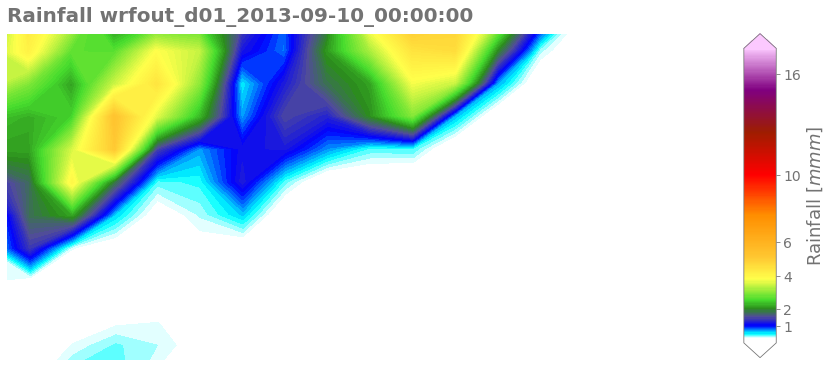

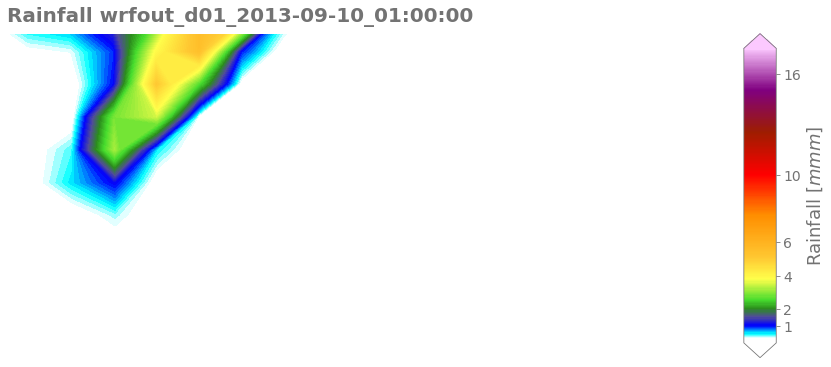

In [32]:
for idd, path_wrf in enumerate(df_info_wrf.path):
    if idd > 0 and idd < 8: 
        ncfile00 = netCDF4.Dataset(df_info_wrf.path[idd-1])
        ncfile11 = netCDF4.Dataset(df_info_wrf.path[idd])
        
        rain = ((wrf.getvar(ncfile11,"RAINSH",timeidx=-1)+
                 wrf.getvar(ncfile11,"RAINC",timeidx=-1)+
                 wrf.getvar(ncfile11,"RAINNC",timeidx=-1)
                )-
                (wrf.getvar(ncfile00,"RAINSH",timeidx=-1)+
                 wrf.getvar(ncfile00,"RAINC",timeidx=-1)+
                 wrf.getvar(ncfile00,"RAINNC",timeidx=-1))
               )

        fig,ax = plt.subplots(
            ncols=1,nrows=1,figsize=(15,6),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

        e = .001
        ymin = np.min(full_dom.LATITUDE.values) + e
        ymax = np.max(full_dom.LATITUDE.values) + e
        xmin = np.min(full_dom.LONGITUDE.values) - e
        xmax = np.max(full_dom.LONGITUDE.values) - e
        
        ax.set_global()
        ax.coastlines(lw=1)
        ax.spines['geo'].set_visible(False)
        lon_grid = np.arange(-180,181,33)
        lat_grid = np.arange(-80,86,33)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                          linewidth=.01, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'}
        ax.set_extent([xmin, xmax, ymin, ymax])
    
        mapa = ax.contourf(
            rain.XLONG.values,
            rain.XLAT.values,
            rain,levels=levels_nuevos,
            cmap=cmap_rain,
            norm=norm_rain,
            extend='both'
        )

        #ax.clabel(maps,inline=True,fmt='%2.1f',fontsize=10)
        aux_tilt = df_info_wrf.path[idd].as_posix().split('/')[-1]
        ax.text(xmin,ymax+.01,f'Rainfall {aux_tilt}',fontsize=20,fontweight='bold')
        cbar_ax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
        cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[1,2,4,6,10,16])
        cbar1.set_label(r'Rainfall $[mmm]$',fontsize=18)
        cbar1.ax.tick_params(labelsize=14)
        plt.show()

## Magdalena

### Create tiff

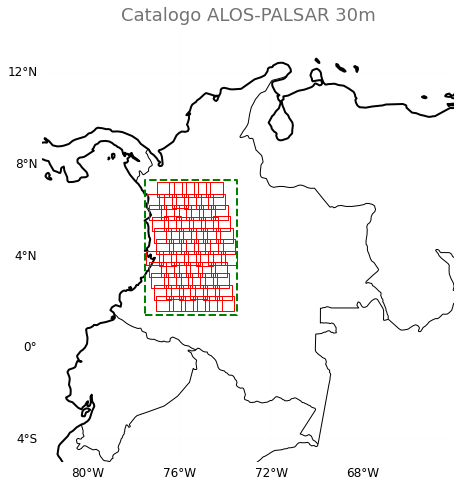

********************************************************************
Name merged DEM =  /Volumes/phd_data/dataset/ALOS/LR/test_hydro_dem.tif
Name merged SLP =  /Volumes/phd_data/dataset/ALOS/LR/test_hydro_slp.tif
********************************************************************


In [34]:
xmin = -77.5
xmax = -73.5
ymin = 1.4
ymax = 7.3
name_out_dem = '{0}/{1}'.format(ruta_dat.as_posix(),'test_hydro_dem.tif')
name_out_slp = '{0}/{1}'.format(ruta_dat.as_posix(),'test_hydro_slp.tif')

catalogo_dem = catalogo_alos(
    xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
    ruta_data=ruta_dem.as_posix(),
    plot='si'
)
catalogo_slp = catalogo_alos(
    xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
    ruta_data=ruta_slp.as_posix(),
    plot='no'
)

os.system('gdal_merge.py -o {0} {1}'.format(
    name_out_dem,' '.join(list(map(lambda x: '{0}/{1}'.format(ruta_dem,x),
                                   catalogo_dem.index))))
         )

os.system('gdal_merge.py -o {0} {1}'.format(
    name_out_slp,' '.join(list(map(lambda x: '{0}/{1}'.format(ruta_slp,x),
                                   catalogo_slp.index))))
         )

print ('********************************************************************')
print ('Name merged DEM = ', name_out_dem)
print ('Name merged SLP = ', name_out_slp)
print ('********************************************************************')

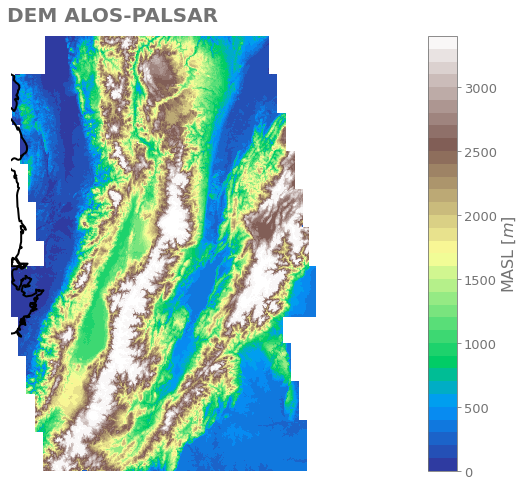

In [35]:
dem_data, lon_dem, lat_dem = get_fromtiff(
    name_tiff=name_out_dem
)
graf_dem_alos(lon_dem,lat_dem,dem_data)

### Plots

In [36]:
full_dom = xr.open_dataset(path_magd.joinpath('Fulldom_hires.nc'))
gw_basin = xr.open_dataset(path_magd.joinpath('GWBASINS.nc'))
gw_buckp = xr.open_dataset(path_magd.joinpath('GWBUCKPARM.nc'))
geo_ldasout = xr.open_dataset(path_magd.joinpath('GEOGRID_LDASOUT_Spatial_Metadata.nc'))

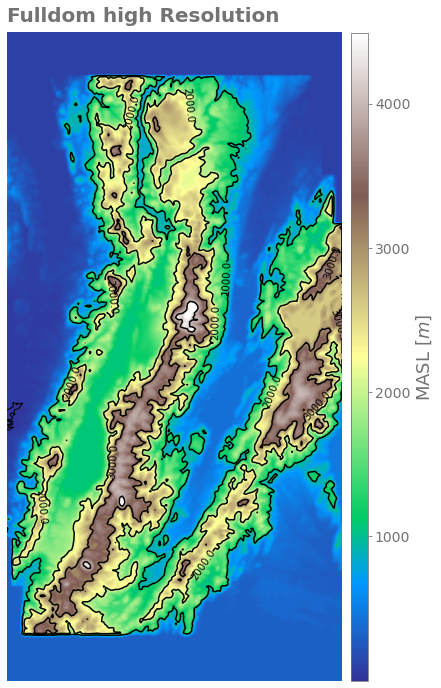

In [37]:
graf_dem_hr(full_dom, 'magd')

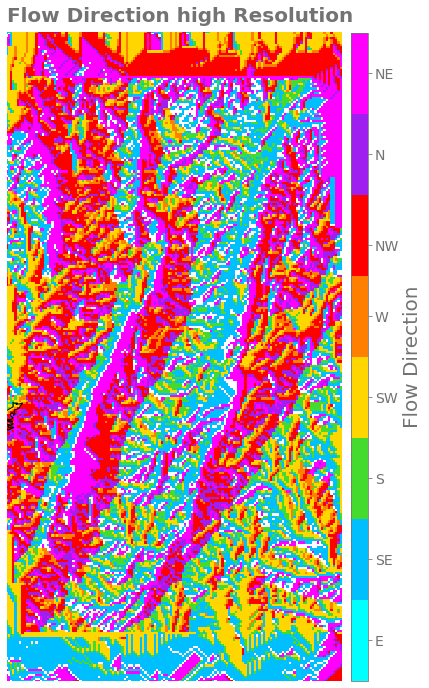

In [38]:
graf_dir_hr(full_dom, 'magd')

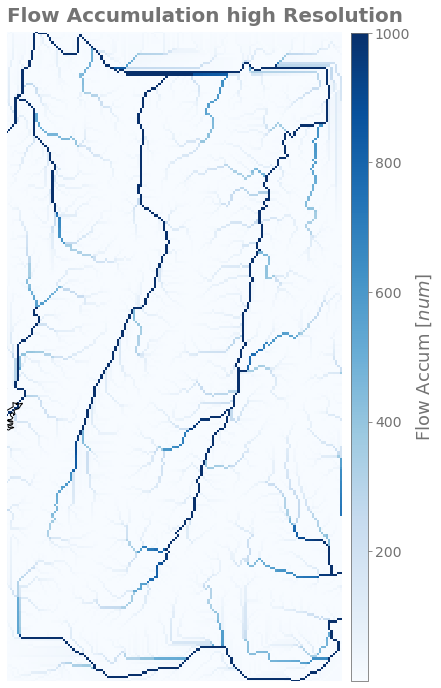

In [39]:
graf_acc_hr(full_dom,'magd')

full_dom.CHANNELGRID.plot()

In [ ]:
full_dom.CHANNELGRID.plot()

### Postpro

In [40]:
ds_out_grid = xr.open_mfdataset(
    f'{path_magd_results.as_posix()}/*.CHRTOUT_GRID2', 
    combine='by_coords'
)

ds_out_domain = xr.open_mfdataset(
    f'{path_magd_results.as_posix()}/*.CHRTOUT_DOMAIN2', 
    combine='by_coords'
)

ds_lsm_domain = xr.open_mfdataset(
    f'{path_magd_results.as_posix()}/*.LSMOUT_DOMAIN', 
    combine='by_coords'
)

In [42]:
ds_out_domain

<xarray.Dataset>
Dimensions:         (time: 217, reference_time: 1, feature_id: 6868)
Coordinates:
  * time            (time) datetime64[ns] 2023-11-01T12:00:00 ... 2023-11-10T...
  * reference_time  (reference_time) datetime64[ns] 2023-11-01T12:00:00
  * feature_id      (feature_id) int32 1 2 3 4 5 6 ... 6864 6865 6866 6867 6868
    latitude        (feature_id) float32 dask.array<chunksize=(6868,), meta=np.ndarray>
    longitude       (feature_id) float32 dask.array<chunksize=(6868,), meta=np.ndarray>
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    order           (time, feature_id) int32 dask.array<chunksize=(1, 6868), meta=np.ndarray>
    elevation       (time, feature_id) float32 dask.array<chunksize=(1, 6868), meta=np.ndarray>
    streamflow      (time, feature_id) float32 dask.array<chunksize=(1, 6868), meta=np.ndarray>
    q_lateral       (time, feature_id) float32 dask.array<chunksize=(1, 6868), meta=np.ndarray>
    velocity        (time, feature_id) float32 dask.array<chunksize=(1, 6868), meta=np.ndarray>
    Head            (time, feature_id) float32 dask.array<chunksize=(1, 6868), meta=np.ndarray>
Attributes: (12/17)
    featureType:                timeSeries
    proj4:                      +proj=merc +lat_ts=30 +lon_0=-79 +x_0=0 +y_0=...
    model_initialization_time:  2023-11-01_12:00:00
    station_dimension:          feature_id
    model_output_valid_time:    2023-11-01_12:00:00
    model_total_valid_times:    0
    ...                         ...
    model_configuration:        default
    dev_OVRTSWCRT:              1
    dev_NOAH_TIMESTEP:          4
    dev_channel_only:           0
    dev_channelBucket_only:     0
    dev:                        dev_ prefix indicates development/internal me...

In [41]:
ds_out_grid

<xarray.Dataset>
Dimensions:         (time: 217, reference_time: 1, x: 148, y: 284)
Coordinates:
  * time            (time) datetime64[ns] 2023-11-01T12:00:00 ... 2023-11-10T...
  * reference_time  (reference_time) datetime64[ns] 2023-11-01T12:00:00
  * x               (x) float64 1.716e+05 1.739e+05 ... 5.001e+05 5.024e+05
  * y               (y) float64 1.057e+05 1.079e+05 ... 7.402e+05 7.424e+05
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    index           (time, y, x) float64 dask.array<chunksize=(1, 284, 148), meta=np.ndarray>
    streamflow      (time, y, x) float32 dask.array<chunksize=(1, 284, 148), meta=np.ndarray>
Attributes:
    model_initialization_time:  2023-11-01_12:00:00
    model_output_valid_time:    2023-11-01_12:00:00
    model_total_valid_times:    0
    Conventions:                CF-1.6
    code_version:               v5.1.2
    model_output_type:          channel_rt
    model_configuration:        default
    proj4:                      +proj=merc +lat_ts=30 +lon_0=-79 +x_0=0 +y_0=...
    GDAL_DataType:              Generic

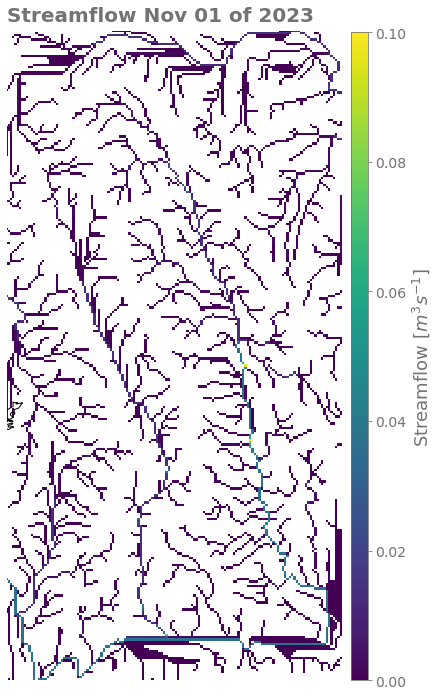

In [43]:
graf_magdalena_streamflow(full_dom, ds_out_grid, 1)

In [44]:
np.where(ds_out_grid.streamflow.values == np.nanmax(ds_out_grid.streamflow.values))

(array([1]), array([178]), array([106]))

In [45]:
ds_out_grid.index.values[1,178,106]

4121.0

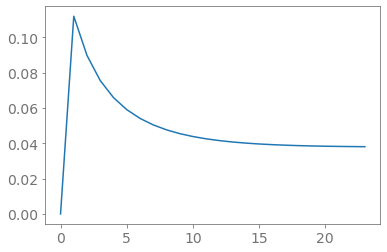

In [46]:
plt.plot(ds_out_grid.streamflow.values[0:24,178,106])

In [ ]:
ds_out_grid.streamflow[1:14].plot(
    col='time', 
    col_wrap=4, 
    vmin=0, 
    aspect=ds_out_grid.x.size/ds_out_grid.y.size
)

plt.show()

In [ ]:
ds_lsm_domain = xr.open_mfdataset(
    f'{path_magd_results.as_posix()}/*.LSMOUT_DOMAIN', 
    combine='by_coords'
)

ds_rt_domain = xr.open_mfdataset(
    f'{path_magd_results.as_posix()}/*.RTOUT_DOMAIN2', 
    combine='by_coords'
)

In [ ]:
ds_rt_domain.info()

In [ ]:
ds_rt_domain

In [ ]:
ds_lsm_domain.info()

In [ ]:
ds_lsm_domain.smc4.isel(time=3).plot()

In [47]:
wrf_path_list = sorted(list(path_magd_results.rglob(f'wrfout*')))
df_info_wrf = {idd: [ii] for idd, ii in enumerate(wrf_path_list)}
df_info_wrf = pd.DataFrame.from_dict(df_info_wrf, orient='index', columns=['path'])

In [48]:
lev  = np.array([0.,5.0,10.0,20.,30.,40.,50.,75.,100.,150,200.,250,300.,350.])/5.
bar_colors  = np.array(\
               [(255, 255, 255),(255, 255, 255),(0, 255, 255),(0, 0, 255),(80,76,153),\
               (44, 141, 29), (70, 220, 45),\
               (255,255,75),(255, 200,50),(255,142,0), (255,0,0),(158, 29, 0),\
               (128,0,128),(252, 201, 255)])
Custom_Color = list(map(lambda x: tuple(ti/255. for ti in x) , bar_colors))
VariableLimits = np.array(lev)
scale_factor=((255-0.)/(VariableLimits.max() - VariableLimits.min()))
new_Limits = list(np.array(np.round((VariableLimits-VariableLimits.min())*\
                                    scale_factor/255.,3),dtype = float))
nueva_tupla=[((new_Limits[i]),Custom_Color[i],) for i in range(len(Custom_Color))]
cmap_rain = clr.LinearSegmentedColormap.from_list('RADAR',nueva_tupla)
levels_nuevos = np.linspace(np.min(VariableLimits),np.max(VariableLimits),255)
norm_rain = clr.BoundaryNorm(boundaries=levels_nuevos, ncolors=256)

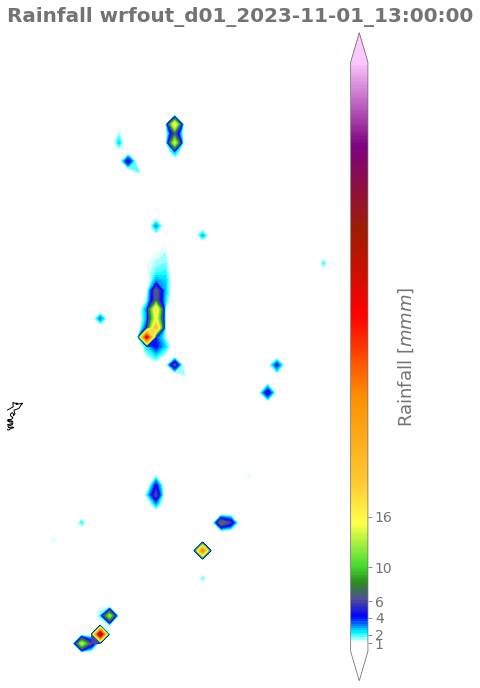

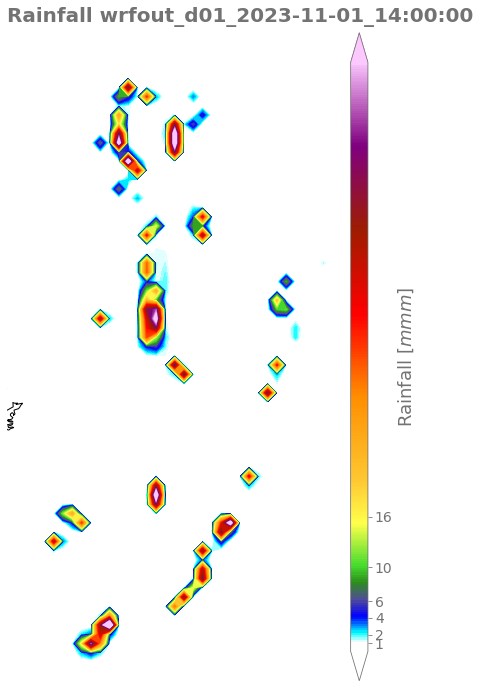

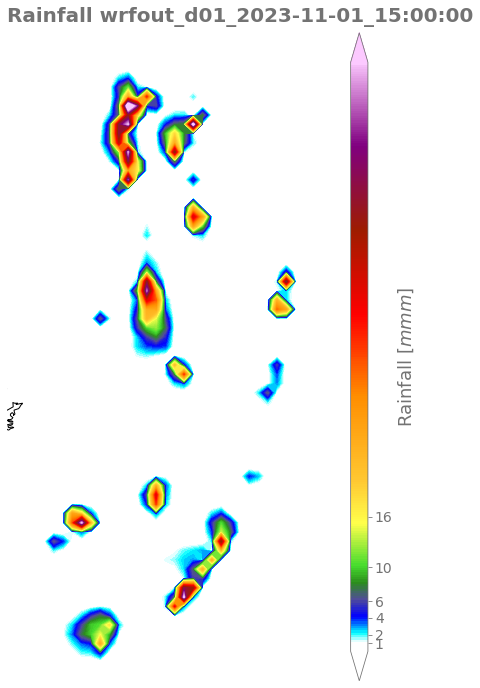

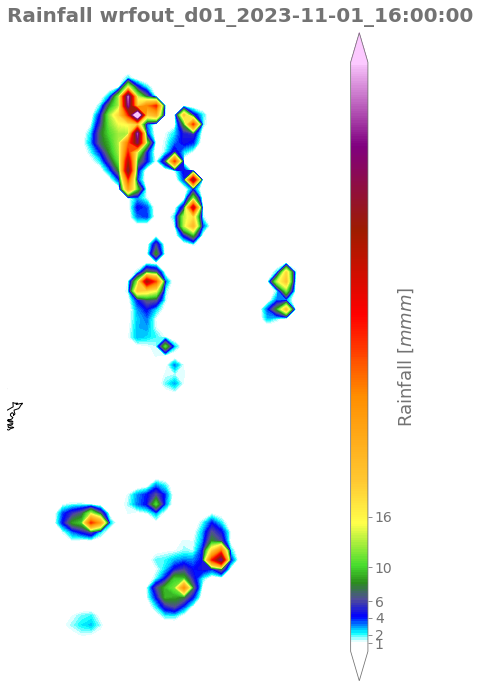

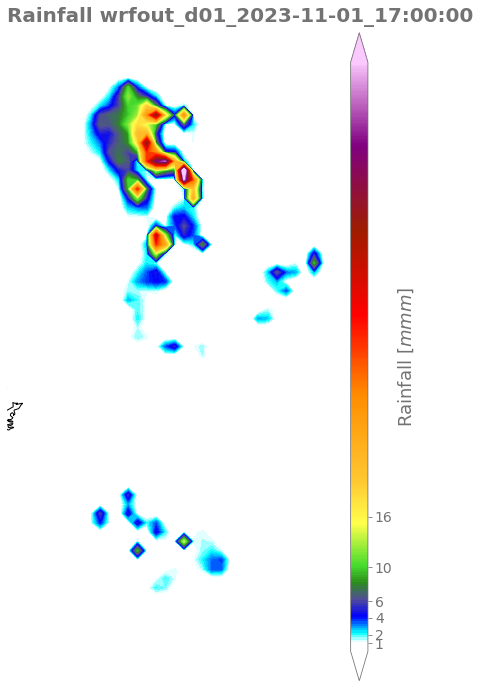

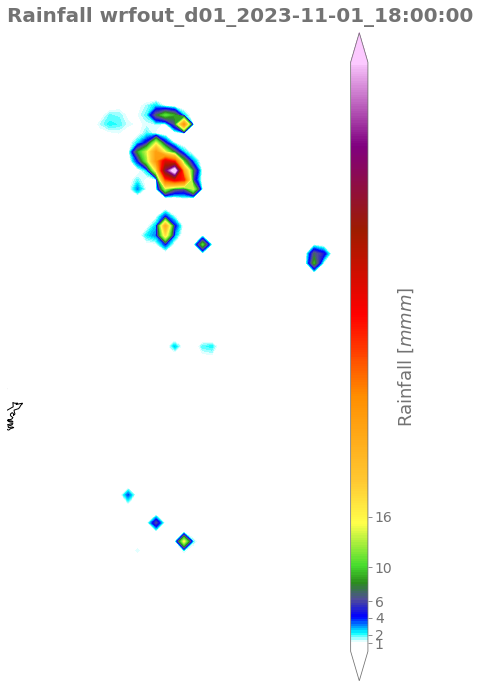

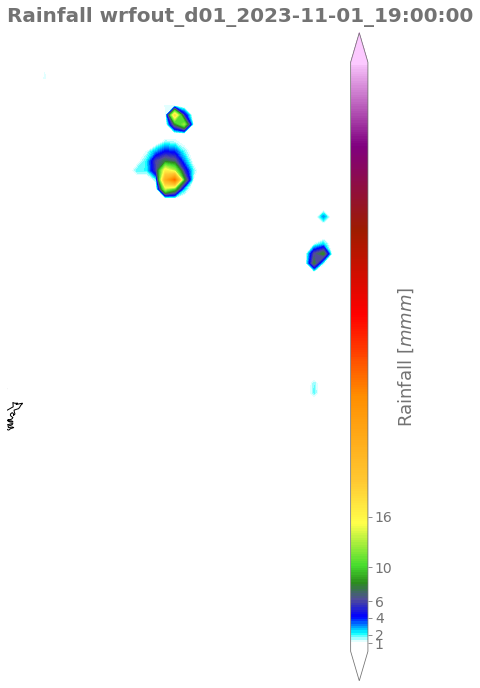

In [49]:
for idd, path_wrf in enumerate(df_info_wrf.path):
    if idd > 0 and idd < 8: 
    #if idd == 1: 
        ncfile00 = netCDF4.Dataset(df_info_wrf.path[idd-1])
        ncfile11 = netCDF4.Dataset(df_info_wrf.path[idd])
        
        rain = ((wrf.getvar(ncfile11,"RAINSH",timeidx=-1)+
                 wrf.getvar(ncfile11,"RAINC",timeidx=-1)+
                 wrf.getvar(ncfile11,"RAINNC",timeidx=-1)
                )-
                (wrf.getvar(ncfile00,"RAINSH",timeidx=-1)+
                 wrf.getvar(ncfile00,"RAINC",timeidx=-1)+
                 wrf.getvar(ncfile00,"RAINNC",timeidx=-1))
               )

        fig,ax = plt.subplots(
            ncols=1,nrows=1,figsize=(6,15),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

        e = .001
        ymin = np.min(full_dom.LATITUDE.values) + e
        ymax = np.max(full_dom.LATITUDE.values) + e
        xmin = np.min(full_dom.LONGITUDE.values) - e
        xmax = np.max(full_dom.LONGITUDE.values) - e
        
        ax.set_global()
        ax.coastlines(lw=1)
        ax.spines['geo'].set_visible(False)
        lon_grid = np.arange(-180,181,33)
        lat_grid = np.arange(-80,86,33)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                          linewidth=.01, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'}
        ax.set_extent([xmin, xmax, ymin, ymax])
    
        mapa = ax.contourf(
            rain.XLONG.values,
            rain.XLAT.values,
            rain,levels=levels_nuevos,
            cmap=cmap_rain,
            norm=norm_rain,
            extend='both'
        )

        #ax.clabel(maps,inline=True,fmt='%2.1f',fontsize=10)
        aux_tilt = df_info_wrf.path[idd].as_posix().split('/')[-1]
        ax.text(xmin,ymax+.1,f'Rainfall {aux_tilt}',fontsize=20,fontweight='bold')
        cbar_ax = fig.add_axes([0.92, 0.202, 0.04, 0.6])
        cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[1,2,4,6,10,16])
        cbar1.set_label(r'Rainfall $[mmm]$',fontsize=18)
        cbar1.ax.tick_params(labelsize=14)
        plt.show()